In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import os

/home/shaunak/.virtualenvs/llm_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config dataset path.
model_path = "distilbert/distilgpt2"
data_path = r"../data/processed_data/train.json"
output_path = r"../output"

# force to use GPU.
assert torch.cuda.is_available(), "Use GPU!"
device = torch.device("cuda")

In [3]:
# Implement a custom callback to record the change of loss value
# in real time during model training.
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

In [4]:
def process_data(tokenizer):
    dataset = load_dataset("json", data_files=data_path, split="train[:1500]")
    print(dataset)

    def format_example(example):
        instruction = f"Question: {example['Question']}\nAnalysis: {example['Complex_CoT']}"
        inputs = tokenizer(
            f"{instruction}\n### Answer: \n{example['Response']}<|endoftext|>",
            padding="max_length",
            truncation=True,
            
            max_length=512,
            return_tensors="pt"
        )
        return {"input_ids": inputs["input_ids"].squeeze(0), "attention_mask": inputs["attention_mask"].squeeze(0)}

    return dataset.map(format_example, remove_columns=dataset.column_names)

In [5]:
# LoRA configuration.
# r means the rank of the low-rank decomposition.
# lora_alpha is the scaling factor.
# target_modules are the modules to be decomposed.
# lora_dropout is the dropout rate.
# task_type is the task type -- Causal Language Model.
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [6]:
# Training arguments.
training_args = TrainingArguments(
    output_dir=output_path,
    per_device_train_batch_size=2,  # storage limited.
    gradient_accumulation_steps=4,  # accumulate gradient, batch_size=8
    num_train_epochs=3,
    learning_rate=3e-4,
    fp16=True,  # open fp16, accelerate training.
    logging_steps=20,
    save_strategy="no",
    report_to="none",
    optim="adamw_torch",
    no_cuda=False,
    dataloader_pin_memory=False,  # use pinned memory to accelerate training.
    remove_unused_columns=False  # prevent error.
)

In [9]:
model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )

In [18]:
params_before = {}
for name, param in model.named_parameters():
    params_before[name] = param.detach().cpu().clone()

trainable params: 811,008 || all params: 82,723,584 || trainable%: 0.9804


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 1500
})
Start training...


Step,Training Loss
20,5.042000
40,0.874300
60,0.686700
80,0.537000
100,0.411100
120,0.339900
140,0.334100
160,0.347800
180,0.300400
200,0.306000


Model saved to ../output
Loss curve saved to loss_curve.png


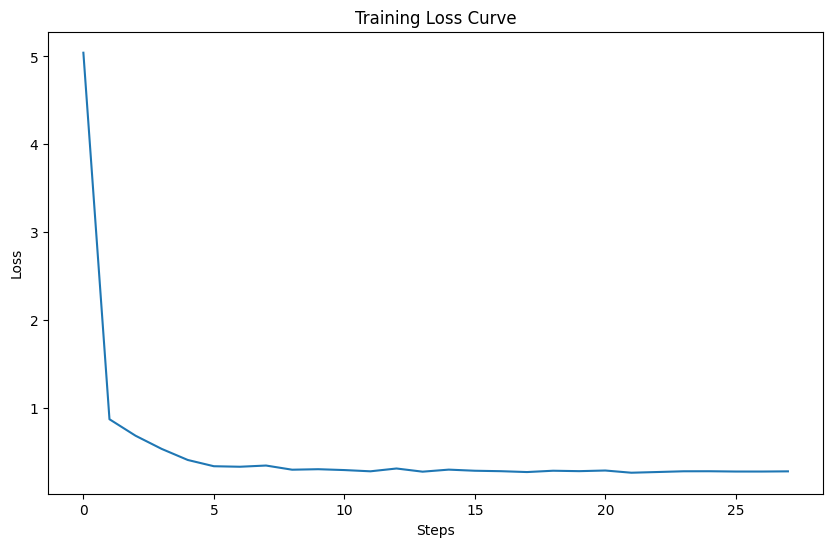

In [25]:
def main():
    # create output path.
    os.makedirs(output_path, exist_ok=True)

    # load tokenizer.
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    # load model.
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    # preprocess data.
    dataset = process_data(tokenizer)

    # loss callback.
    loss_callback = LossCallback()

    # data collator.
    def data_collator(data):
        batch = {
            "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
            "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
            # use input_ids as labels.
            "labels": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device)
        }
        return batch

    # create trainer.
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=data_collator,
        callbacks=[loss_callback]
    )

    # start training.
    print("Start training...")
    trainer.train()

    # save model.
    trainer.model.save_pretrained(output_path)
    print(f"Model saved to {output_path}")

    # plot loss curve.
    plt.figure(figsize=(10, 6))
    plt.plot(loss_callback.losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(output_path, "loss_curve.png"))
    print("Loss curve saved to loss_curve.png")
    return model

if __name__ == "__main__":
    trained_model = main()

In [26]:
params_after = {}
for name, param in trained_model.named_parameters():
    params_after[name] = param.detach().cpu().clone()

In [28]:
params_before.keys()

dict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.c

In [43]:
for key in params_before.keys():
    transformed_key = "base_model.model." + key
    if transformed_key not in params_after:
        print(f"{key} not present in params after training!")

transformer.h.0.attn.c_attn.weight not present in params after training!
transformer.h.0.attn.c_attn.bias not present in params after training!
transformer.h.0.attn.c_proj.weight not present in params after training!
transformer.h.0.attn.c_proj.bias not present in params after training!
transformer.h.0.mlp.c_proj.weight not present in params after training!
transformer.h.0.mlp.c_proj.bias not present in params after training!
transformer.h.1.attn.c_attn.weight not present in params after training!
transformer.h.1.attn.c_attn.bias not present in params after training!
transformer.h.1.attn.c_proj.weight not present in params after training!
transformer.h.1.attn.c_proj.bias not present in params after training!
transformer.h.1.mlp.c_proj.weight not present in params after training!
transformer.h.1.mlp.c_proj.bias not present in params after training!
transformer.h.2.attn.c_attn.weight not present in params after training!
transformer.h.2.attn.c_attn.bias not present in params after traini

In [44]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [45]:
trained_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-5): 6 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
          

In [38]:
params_after.keys()

dict_keys(['base_model.model.transformer.wte.weight', 'base_model.model.transformer.wpe.weight', 'base_model.model.transformer.h.0.ln_1.weight', 'base_model.model.transformer.h.0.ln_1.bias', 'base_model.model.transformer.h.0.attn.c_attn.base_layer.weight', 'base_model.model.transformer.h.0.attn.c_attn.base_layer.bias', 'base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.0.attn.c_proj.base_layer.weight', 'base_model.model.transformer.h.0.attn.c_proj.base_layer.bias', 'base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight', 'base_model.model.transformer.h.0.ln_2.weight', 'base_model.model.transformer.h.0.ln_2.bias', 'base_model.model.transformer.h.0.mlp.c_fc.weight', 'base_model.model.transformer.h.0.mlp.c_fc.bias', 'base_model.model.transformer.h.0.mlp.c_proj.base_layer.weight', 'base_mo

In [ ]:
dict(trained_model.named_modules())["base_model.model.transformer.h.0.attn.c_attn"]

In [115]:
# Dummy input
input_text = "Hello, how are you?"
tokenizer = AutoTokenizer.from_pretrained(model_path)
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Forward pass through the attention layer
with torch.no_grad():
    inputs = trained_model.model.transformer.wte(inputs.input_ids)
    c_attn = trained_model.model.transformer.h[0].attn.c_attn
    conv = c_attn.base_layer
    A = c_attn.lora_A["default"].weight
    B = c_attn.lora_B["default"].weight

    mult = (B @ A).T
    mult = mult.to(torch.float16)
    mult = inputs @ mult
    custom_output = conv(inputs) + mult
    lora_output = trained_model.model.transformer.h[0].attn.c_attn(
        inputs
    )
    print(custom_output)

print(lora_output)

tensor([[[ 1.3895e-03, -2.3328e-01,  1.1973e+00,  ...,  1.3220e-01,
          -2.4646e-01,  2.7246e-01],
         [ 1.6455e-01, -2.1543e+00, -1.0022e-01,  ...,  2.0691e-02,
           1.2549e-01,  2.7759e-01],
         [-1.0651e-01, -2.6758e-01, -5.6787e-01,  ..., -9.2224e-02,
          -2.0923e-01,  2.6782e-01],
         [ 4.7632e-01, -1.0273e+00, -6.9580e-01,  ...,  1.4709e-01,
           1.9226e-01,  1.5137e-01],
         [-1.2286e-01, -1.8037e+00, -1.9922e+00,  ..., -7.2693e-02,
           5.0995e-02,  3.1470e-01],
         [-1.3857e+00, -2.1113e+00,  5.8105e-01,  ..., -6.9946e-02,
           1.7041e-01,  6.5674e-02]]], device='cuda:0', dtype=torch.float16)
tensor([[[-1.6642e-03, -2.4243e-01,  1.2021e+00,  ...,  1.2805e-01,
          -2.4084e-01,  2.7515e-01],
         [ 1.6370e-01, -2.1406e+00, -9.8328e-02,  ...,  2.8687e-02,
           1.2622e-01,  2.8149e-01],
         [-1.0724e-01, -2.7490e-01, -5.6250e-01,  ..., -9.0088e-02,
          -2.1265e-01,  2.6733e-01],
         [ 4.74

In [52]:
input_text = "Hello, how are you?"
tokenizer = AutoTokenizer.from_pretrained(model_path)
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Forward pass through the attention layer
with torch.no_grad():
    output = model.transformer.h[0].attn(
        model.transformer.wte(inputs.input_ids)
    )

print(output)

(tensor([[[ 5.9662e-03, -6.4502e-01,  8.1348e-01,  ..., -4.4739e-02,
          -1.0846e-01,  1.1938e-01],
         [-2.1094e-01, -7.8223e-01,  9.7852e-01,  ...,  8.9874e-03,
          -6.7139e-02,  2.0386e-01],
         [-1.8005e-01,  1.1865e+00,  2.8491e-01,  ...,  1.8282e-03,
          -4.8492e-02,  1.3892e-01],
         [-9.4043e-01,  7.9834e-01,  6.4600e-01,  ...,  4.9988e-02,
          -4.3640e-02,  1.4905e-01],
         [-1.6602e+00,  1.9355e+00,  5.1855e-01,  ...,  2.6077e-02,
           4.5288e-02,  8.8745e-02],
         [-1.7004e-01,  9.4775e-01,  7.8906e-01,  ...,  6.8176e-02,
          -1.2231e-01,  1.2903e-01]]], device='cuda:0', dtype=torch.float16), None)


In [55]:
output[0].shape

torch.Size([1, 6, 768])

In [56]:
lora_output[0].shape

torch.Size([1, 6, 768])

In [58]:
(output[0] - lora_output[0])

tensor([[[ 0.6519,  0.2373, -1.3818,  ..., -0.2002,  0.1562, -0.0157],
         [ 0.0896,  0.1294, -0.2100,  ...,  0.0294,  0.0270, -0.0498],
         [ 0.2969, -0.1543, -0.3987,  ...,  0.0509,  0.0052, -0.0853],
         [-0.4858, -1.6016, -0.2412,  ..., -0.0413, -0.0234,  0.2356],
         [ 0.3691,  1.9355,  0.5186,  ..., -0.0152,  0.0482,  0.0887],
         [-1.4512,  0.2700,  0.7891,  ...,  0.0440, -0.0495,  0.0829]]],
       device='cuda:0', dtype=torch.float16)

In [61]:
model.named_modules()

<generator object Module.named_modules at 0x79338ce8edc0>

In [74]:
for name, module in trained_model.named_modules():
    if "lora_A" in dict(module.named_modules()) and "base_layer" in dict(module.named_modules()):
        print(f"Layer: {name}")
        base_weight = module.base_layer.weight
        print("Weight corresponding to LORA : ", base_weight.shape)
        lora_A = module.lora_A["default"].weight
        lora_B = module.lora_B["default"].weight
        updated_W = base_weight + (lora_B @ lora_A).T
        print("Updated w shape : ", updated_W.shape)
        print("LoRA A:", module.lora_A["default"].weight.shape)
        print("LoRA B:", module.lora_B["default"].weight.shape)
        print("-" * 50)

Layer: base_model.model.transformer.h.0.attn.c_attn
Weight corresponding to LORA :  torch.Size([768, 2304])
Updated w shape :  torch.Size([768, 2304])
LoRA A: torch.Size([16, 768])
LoRA B: torch.Size([2304, 16])
--------------------------------------------------
Layer: base_model.model.transformer.h.0.attn.c_proj
Weight corresponding to LORA :  torch.Size([768, 768])
Updated w shape :  torch.Size([768, 768])
LoRA A: torch.Size([16, 768])
LoRA B: torch.Size([768, 16])
--------------------------------------------------
Layer: base_model.model.transformer.h.0.mlp.c_proj
Weight corresponding to LORA :  torch.Size([3072, 768])
Updated w shape :  torch.Size([3072, 768])
LoRA A: torch.Size([16, 3072])
LoRA B: torch.Size([768, 16])
--------------------------------------------------
Layer: base_model.model.transformer.h.1.attn.c_attn
Weight corresponding to LORA :  torch.Size([768, 2304])
Updated w shape :  torch.Size([768, 2304])
LoRA A: torch.Size([16, 768])
LoRA B: torch.Size([2304, 16])
---